We need to cut off the excess area, to reduce the image to a size, that is manageable by the NN. This should be automated in a future app, but to get starting with the training this is done manually.

Still, to speed up the process we use a Notebook Widget to find the coordinates of the points, where we want to cut the image. It's pretty makeshift, but does the job.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

from pathlib import Path
import os

In [2]:
# to have interactive plots in the notebook
%matplotlib notebook

In [10]:
# the folder structure for the output is copied from the input
in_path = 'data/pic/src/test/incorrect'
out_path = Path(in_path.replace('src','crop'))
in_path = Path(in_path)

out_path.mkdir(exist_ok=True, parents = True)

### Widget description:
The widget shows an image. You add a line by __clicking__ in the image, either horizontally or vertically. To choose in which way to add the line you can __press__ __'h'__ for horizontal, __'v'__ for vertical and __'m'__ to switch between the modes. When clicking in horizontal mode, the hight at which the line is inserted is saved, for vertical mode, the width is saved.

You can reset lines and the coordinates by __pressing 'r'__ or save the coordinates to a dict (with the filename of the image) and move to the next image, by __pressing 's'__. The dict can be used to crop the images later on.

In [11]:
# load the current image from a filepath
def load_im(filepath):
    global im
    
    im = plt.imread(filepath)

# get the hight and width of the current image and reset the position dict
# set the line-mode to 'horizontal'
# remove last image and show current
def init(im):
    global height, width, mode, pos_dict, current_file
    
    height, width = im.shape[0:-1]
    pos_dict = {'hor': [], 'vert': []}
    mode = 0
    
    plt.clf()
    plt.title(current_file)
    plt.imshow(im)
    
# draw a line ontop of the current image, when mousebutton is clicked, dependent on the current mode
def draw_line(event):
    global pos_dict
    
    # save the position at which the click occured
    x, y = event.xdata, event.ydata 
    
    # add a horizontal line and saves the hight at which it is inserted
    if mode == 0: 
        plt.hlines(y, 10, width - 10, 'r', zorder = 11)
        pos_dict['hor'].append(y)
        
    # add a vertical line and saves the width at which it is inserted   
    if mode == 1: 
        plt.vlines(x, 10, height - 10, 'r', zorder = 12)
        pos_dict['vert'].append(x)
    
    # plots the line
    plt.gcf().canvas.draw()
    
# returns the ordered values from the pos_dict
def crop_position(pos_dict):
    hor = pos_dict['hor']
    vert = pos_dict['vert']
    return min(hor), max(hor), min(vert), max(vert) 
    
def change_mode(event):
    global mode, im, pos_dict, crop_poss, current_file
    
    # to add a horizontal line
    if event.key == 'h': 
        mode = 0
        
    # to add a vertical line
    elif event.key == 'v':
        mode = 1
        
    # switch between the modes
    elif event.key == 'm': 
        if mode == 0:
            mode = 1
        elif mode == 1:
            mode = 0
            
    # reset current picture
    elif event.key == 'r': 
        init(im)
        
    # save determined positions and move to next picture    
    elif event.key == 's': 
        crop_poss[current_file] = crop_position(pos_dict)
        
        try:
            current_file = next(iter_files)
        except:
            plt.gcf().canvas.mpl_disconnect(cid0)
            plt.gcf().canvas.mpl_disconnect(cid1)
            
        load_im(in_path / current_file)
        init(im)

### Make a list of all files that should cropped

In [12]:
files = [f for f in os.listdir(in_path)]
# Create an iterable object
iter_files = iter(files)
# Create a dictionay to hold the filename and the position at which the corresponding image has to be cut
crop_poss = {}
print('No. of files: {},\nFirst 5 files: \n{}'.format(len(files), files[:5]))

No. of files: 52,
First 5 files: 
['DSC_0234.JPG', 'DSC_0209.JPG', 'DSC_0236.JPG', 'DSC_0210.JPG', 'DSC_0194.JPG']


### Widget

<IPython.core.display.Javascript object>


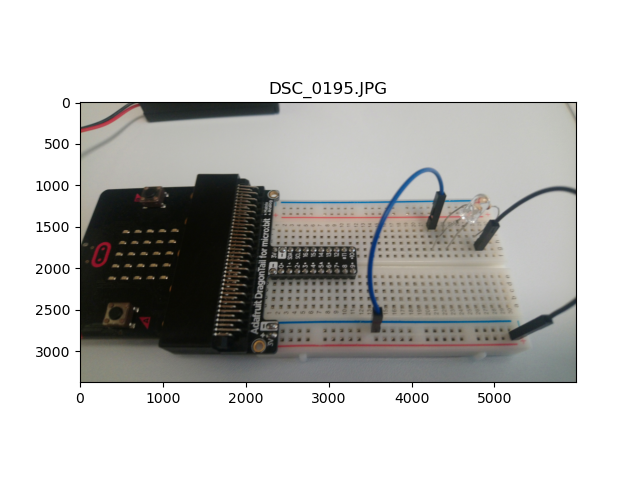

In [13]:
# initialize first image
current_file =  next(iter_files)
filepath = in_path / current_file
im = plt.imread(filepath)
init(im)

# interact with plot
cid0 = plt.gcf().canvas.mpl_connect('button_press_event', draw_line)
cid1 = plt.gcf().canvas.mpl_connect('key_press_event', change_mode)

Now, `crop_poss` contains four values for each image, callable by the filename. The first two values are on the $y$-axis, the second two on the $x$-axis. Everything between the values shall be kept.

In [14]:
len(crop_poss)

52

### Crop the images and save to .jpg

In [8]:
# crops the image and saves it to a certain path
def save_im(im, filename):
    y1, y2, x1, x2  = crop_poss[filename]
    im_crop = im[int(y1):int(y2), int(x1):int(x2)]
    plt.imsave(out_path / filename, im_crop)

In [15]:
n = len(crop_poss)
i = 0

for i,file in enumerate(files):
    im = plt.imread(in_path / file)
    save_im(im, file)
    print('{:3.2f}% processed'.format((i+1)/n*100), end = '\r', flush = True)